## Test action chunk reconstruction using LDS
Test how good we can reconstruct the action chunk from the tokenized action.

Concat will make different trajs append to each other, which is not what we want.

Need to figure out:
1. what is the error that we can accept?
2. why they use BPE? How good is the tokenization?

Data table (data is fake at the moment):
| Method Name | Reconstruction Error | Parameter Count | Comment |
|-------------|----------------------|-----------------|---------|
| original A    | 0.05                 | 1000            | Good performance with low error |
| Eigen Decomposition    | 0.10                 | 1500            | Higher error but more parameters |
| Sparse A    | 0.07                 | 1200            | Balanced approach |


<KeysViewHDF5 ['demo_0', 'demo_1', 'demo_10', 'demo_100', 'demo_101', 'demo_102', 'demo_103', 'demo_104', 'demo_105', 'demo_106', 'demo_107', 'demo_108', 'demo_109', 'demo_11', 'demo_110', 'demo_111', 'demo_112', 'demo_113', 'demo_114', 'demo_115', 'demo_116', 'demo_117', 'demo_118', 'demo_119', 'demo_12', 'demo_120', 'demo_121', 'demo_122', 'demo_123', 'demo_124', 'demo_125', 'demo_126', 'demo_127', 'demo_128', 'demo_129', 'demo_13', 'demo_130', 'demo_131', 'demo_132', 'demo_133', 'demo_134', 'demo_135', 'demo_136', 'demo_137', 'demo_138', 'demo_139', 'demo_14', 'demo_140', 'demo_141', 'demo_142', 'demo_143', 'demo_144', 'demo_145', 'demo_146', 'demo_147', 'demo_148', 'demo_149', 'demo_15', 'demo_150', 'demo_151', 'demo_152', 'demo_153', 'demo_154', 'demo_155', 'demo_156', 'demo_157', 'demo_158', 'demo_159', 'demo_16', 'demo_160', 'demo_161', 'demo_162', 'demo_163', 'demo_164', 'demo_165', 'demo_166', 'demo_167', 'demo_168', 'demo_169', 'demo_17', 'demo_170', 'demo_171', 'demo_172', '

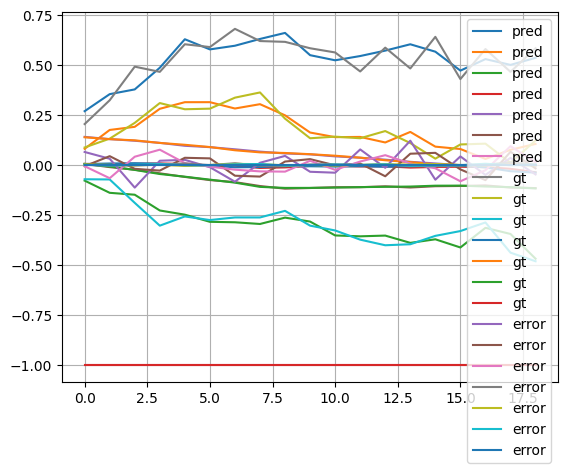

Approximated A matrix:
[[-0.09268992  0.3021844  -0.27635267 -0.00336273 -0.00422509 -0.02827098
   0.        ]
 [ 0.70941791  0.37458364  0.37369868 -0.01565974  0.02160663 -0.03652825
   0.        ]
 [-0.54139093 -0.39035417  0.565537   -0.00290025  0.04681036 -0.00284005
   0.        ]
 [-0.53249381 -2.31175673  1.75829259  1.06408728 -0.07955026  0.42291573
   0.        ]
 [-0.06677518  1.31711508 -0.32721682  0.14922035  0.788538    0.08603848
   0.        ]
 [-0.28813289  1.44005346  0.02055174 -0.14556666  0.07566669  0.64112896
   0.        ]
 [-0.28449895  0.12689035  0.03732047  0.01936953 -0.02227699  0.01921298
   1.        ]]
A_sparse:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 43 stored elements and shape (7, 7)>
  Coords	Values
  (0, 0)	-0.09268991818769037
  (0, 1)	0.3021843970396405
  (0, 2)	-0.27635267154111354
  (0, 3)	-0.003362734592042445
  (0, 4)	-0.0042250934410583705
  (0, 5)	-0.028270982472747633
  (1, 0)	0.7094179071833934
  (1, 1)	0.3745836

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import h5py

from scipy import sparse

def sparsify_matrix(A, threshold=1e-6):
    # Zero out small elements
    A[np.abs(A) < threshold] = 0
    # Convert to sparse format
    A_sparse = sparse.csr_matrix(A)
    return A_sparse

## Read state and action data
state_data = []
action_data = []
with h5py.File('/srv/rl2-lab/flash7/zhenyang/data/robomimic-sim/low_dim_v141.hdf5', 'r') as f:
    f = f['data']
    print(f.keys())
    print(f['demo_0'].keys())
    for demo in f.keys():
        state_data.append(f[demo]['states'][:])
        action_data.append(f[demo]['actions'][:])

state_data_array = np.concatenate(state_data, axis=0)
action_data_array = np.concatenate(action_data, axis=0)

print(state_data_array.shape)
print(action_data_array.shape)

###########################
### Normalize the data ###
state_mean = np.mean(state_data_array, axis=0)
state_std = np.std(state_data_array, axis=0)
state_data_array = (state_data_array - state_mean) / state_std

action_mean = np.mean(action_data_array, axis=0)
action_std = np.std(action_data_array, axis=0)
action_data_array = (action_data_array - action_mean) / action_std

# assumption1: actions at each dim are dependent (LDS)
# but this assumption is not good for other embodiment (e.g. gripper shouldn't affect eef_pose), and fix the dim we can explore

# Using least squares to approximate the A matrix of test_seq which is a linear system trajectory
# Assuming the linear system is of the form: x_{t+1} = A * x_t
# We need to solve for A using least squares
test_seq = action_data[0][:20,:] # 20x7 1s data

# Prepare the data matrices
X = test_seq[:-1]  # x_t
Y = test_seq[1:]   # x_{t+1}

# Solve for A using least squares: A = (X^T * X)^(-1) * X^T * Y
A, residuals, rank, s = np.linalg.lstsq(X, Y, rcond=None)
A_sparse = sparsify_matrix(A)
# reconstruction_error = np.sum(residuals)
# print("Reconstruction error:", reconstruction_error)

X_pred = np.dot(X, A)
print(f"reconstruction error: {np.mean(np.abs(X_pred - Y), axis=0)}")
plt.plot(X_pred, label='pred')
plt.plot(Y, label='gt')
plt.plot(X_pred - Y, label='error')
plt.legend()
plt.grid()
plt.show()

print("Approximated A matrix:")
# np.set_printoptions(precision=3)
print(A)
print("A_sparse:")
print(A_sparse)

# Perform Eigen Decomposition for matrix A
eigenvalues, eigenvectors = np.linalg.eig(A)

print("Eigenvalues:")
print(eigenvalues)
print("Eigenvectors:")
print(eigenvectors)


## Test of pi0 FAST tokenizer
Test the input output error side by side with LDS-Tokenizer

/srv/rl2-lab/flash7/zhenyang/miniconda3/envs/openpi/lib/python3.12/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, confi

tokens number: 29
tokens are: [[372, 298, 322, 1635, 502, 431, 282, 727, 358, 382, 278, 358, 382, 700, 290, 360, 292, 1261, 360, 290, 416, 636, 456, 456, 515, 433, 413, 951, 777]]
decoded actions are: (1, 20, 7)
[0.02192373 0.02291272 0.02619857 0.00965753 0.00997295 0.01198217
 0.00623059]


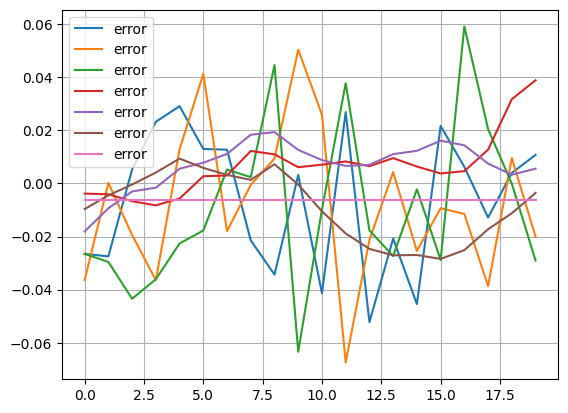

In [7]:
import os
import sys

# Set all cache directories before any HF imports
cache_dir = '/srv/rl2-lab/flash7/zhenyang/.cache'
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HF_HOME'] = cache_dir
os.environ['HF_DATASETS_CACHE'] = cache_dir
os.environ['XDG_CACHE_HOME'] = cache_dir

# Clear any existing HF modules from sys.modules
for module in list(sys.modules.keys()):
    if module.startswith('transformers') or module.startswith('huggingface'):
        del sys.modules[module]

import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoProcessor

# Load the tokenizer from the Hugging Face hub
tokenizer = AutoProcessor.from_pretrained("physical-intelligence/fast", trust_remote_code=True)

# Tokenize & decode action chunks (we use dummy data here)
# action_data = np.random.rand(1, 20, 14)    # one batch of action chunks
action_data = test_seq[np.newaxis, :, :]
tokens = tokenizer(action_data)              # tokens = list[int]
print(f"tokens number: {len(tokens[0])}")
print(f"tokens are: {tokens}")
decoded_actions = tokenizer.decode(tokens)
print(f"decoded actions are: {decoded_actions.shape}")

# plt.plot(decoded_actions[0], label='decoded')
# plt.plot(action_data[0], label='gt')
print(np.mean(np.abs(decoded_actions[0] - action_data[0]), axis=0))
plt.plot(decoded_actions[0] - action_data[0], label='error')
plt.legend()
plt.grid()
plt.show()


## Test from FAST code

Using action = [20x7] as example, we will have DCT coeff = [20x7]
Then we will have bytes = [20x7]. (in this level we can compete, we are using less with LDS-Tokenizer)
After BPE, we will have tokens ~= 29

In [3]:

from scipy.fft import dct

scale = 10
min_token = 0

dct_coeff = dct(test_seq, axis=1, norm="ortho")
print(dct_coeff)
dct_coeff = np.around(dct_coeff * scale) # to get integer to change to str
print(dct_coeff)

tokens = []
tokens_str = []
for elem in dct_coeff:
    token_str = "".join(map(chr, np.maximum(elem.flatten() - min_token, 0).astype(int)))
    tokens_str.append(token_str)
    # tokens.append(tokenizer(token_str)["input_ids"])

print(len(tokens_str))
print(tokens_str)

#     tokens.append(self.bpe_tokenizer(token_str)["input_ids"])
# return tokens

[[-0.31503296  0.48069772 -0.53129802  0.49849832 -0.35583117  0.17752921
  -0.05443225]
 [-0.23973001  0.6131237  -0.39658417  0.59347916 -0.31512271  0.14862685
  -0.09567333]
 [-0.18596946  0.70090303 -0.333525    0.62560977 -0.28775217  0.15004443
  -0.09827865]
 [-0.14492362  0.80281791 -0.2051036   0.73143427 -0.24616738  0.09254751
  -0.15897207]
 [-0.17404397  0.81578098 -0.1645989   0.74549509 -0.27890196 -0.01797064
  -0.24801259]
 [-0.12795762  0.89315733 -0.11117311  0.77845125 -0.22039001  0.04629696
  -0.1946125 ]
 [-0.14890924  0.89175473 -0.10937913  0.77193516 -0.21604039  0.03100741
  -0.2063374 ]
 [-0.10402766  0.97515743 -0.05484441  0.77859645 -0.20955788  0.02778784
  -0.20539021]
 [-0.1287251   0.96549491 -0.08083187  0.73672818 -0.23031405 -0.00656719
  -0.21995692]
 [-0.16858572  0.91921658 -0.11151795  0.74541254 -0.16700829  0.07314696
  -0.16323968]
 [-0.24827838  0.84576045 -0.11137584  0.79021177 -0.12154273  0.08848684
  -0.17248553]
 [-0.2650114   0.8337

## Parameters space analysis
1. How many tokens to represent the action chunk?
2. What kind of characteristic of parameters we have?